In [1]:
# 1. IMPORT LIBRARIES
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

In [2]:
# 2. LOAD DATASETS
# ================================

# Paths (as provided)
HISTORICAL_PATH = "/content/historical_data.csv"
FEAR_GREED_PATH = "/content/fear_greed_index.csv"

# Load CSVs
trades = pd.read_csv(HISTORICAL_PATH)
sentiment = pd.read_csv(FEAR_GREED_PATH)

print("Trades Shape:", trades.shape)
print("Sentiment Shape:", sentiment.shape)

Trades Shape: (41760, 16)
Sentiment Shape: (2644, 4)


/tmp/ipython-input-3161869491.py:9: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv(HISTORICAL_PATH)


In [3]:
# 3. DATA CLEANING & PREPROCESSING

# Convert timestamps
trades['date'] = pd.to_datetime(trades['Timestamp'], unit='ms').dt.date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Keep relevant sentiment columns
sentiment = sentiment[['date', 'value', 'classification']]

# Ensure numeric columns
trades['Closed PnL'] = pd.to_numeric(trades['Closed PnL'], errors='coerce')
trades['Size USD'] = pd.to_numeric(trades['Size USD'], errors='coerce')

# Drop missing values
trades.dropna(subset=['Closed PnL', 'Size USD'], inplace=True)

In [4]:
# 4. MERGE DATASETS

merged_df = trades.merge(sentiment, on='date', how='inner')

print("Merged Dataset Shape:", merged_df.shape)

Merged Dataset Shape: (33969, 19)


In [5]:
# 5. PERFORMANCE ANALYSIS BY SENTIMENT

sentiment_perf = merged_df.groupby('classification').agg(
    total_trades=('Closed PnL', 'count'),
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    median_pnl=('Closed PnL', 'median'),
    avg_trade_size=('Size USD', 'mean')
).reset_index()

print("\nTrader Performance by Market Sentiment:")
print(sentiment_perf)


Trader Performance by Market Sentiment:
  classification  total_trades     total_pnl     avg_pnl  median_pnl  \
0  Extreme Greed          5520  1.737160e+05   31.470291      0.7425   
1           Fear         21607  3.400552e+06  157.381963      0.0000   
2          Greed          5278  7.063433e+04   13.382783      0.0000   
3        Neutral          1564  1.195721e+05   76.452752      0.0000   

   avg_trade_size  
0     5482.944120  
1    14971.390927  
2    10872.330237  
3     8809.184201  


In [6]:
# 6. BUY vs SELL BEHAVIOR ANALYSIS

side_perf = merged_df.groupby(['classification', 'Side']).agg(
    trades=('Closed PnL', 'count'),
    avg_pnl=('Closed PnL', 'mean')
).reset_index()

print("\nBuy vs Sell Performance:")
print(side_perf)


Buy vs Sell Performance:
  classification  Side  trades     avg_pnl
0  Extreme Greed   BUY    2721   35.054985
1  Extreme Greed  SELL    2799   27.985491
2           Fear   BUY   10718  237.015517
3           Fear  SELL   10889   78.998968
4          Greed   BUY    2516  -86.870705
5          Greed  SELL    2762  104.707105
6        Neutral   BUY     712   29.005766
7        Neutral  SELL     852  116.103286


In [7]:
# 7. VOLATILITY & RISK ANALYSIS

risk_analysis = merged_df.groupby('classification').agg(
    pnl_std=('Closed PnL', 'std'),
    pnl_min=('Closed PnL', 'min'),
    pnl_max=('Closed PnL', 'max')
).reset_index()

print("\nRisk Metrics by Sentiment:")
print(risk_analysis)



Risk Metrics by Sentiment:
  classification      pnl_std       pnl_min       pnl_max
0  Extreme Greed   334.057140  -21524.40000    2327.24128
1           Fear  1904.665211  -29370.11980  135329.09010
2          Greed  1878.522458 -117990.10410   29999.90625
3        Neutral  1292.540311  -18360.67007   18282.19011


In [8]:
# 8. VISUALIZATIONS


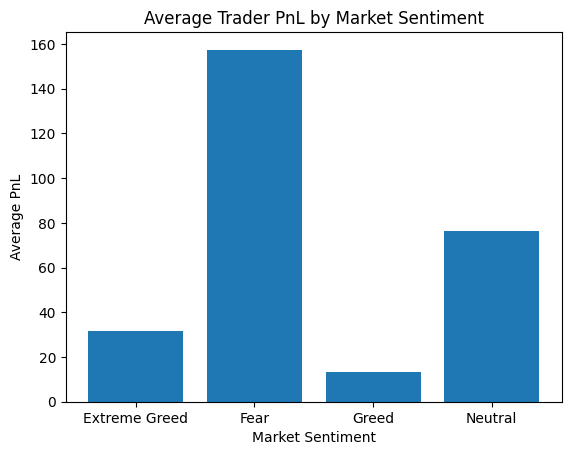

In [9]:
# ---- Average PnL by Sentiment ----
plt.figure()
plt.bar(sentiment_perf['classification'], sentiment_perf['avg_pnl'])
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.title("Average Trader PnL by Market Sentiment")
plt.show()

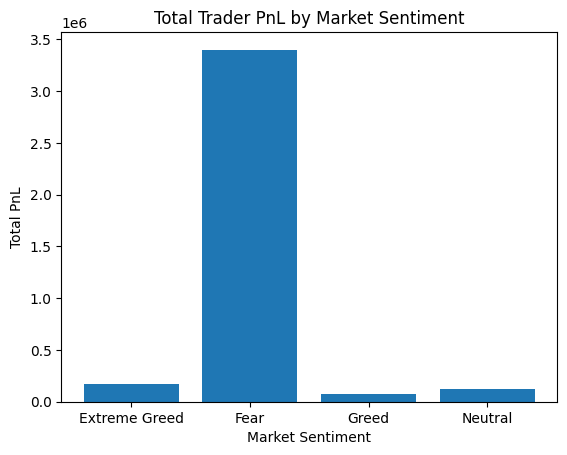

In [10]:
# ---- Total PnL by Sentiment ----
plt.figure()
plt.bar(sentiment_perf['classification'], sentiment_perf['total_pnl'])
plt.xlabel("Market Sentiment")
plt.ylabel("Total PnL")
plt.title("Total Trader PnL by Market Sentiment")
plt.show()

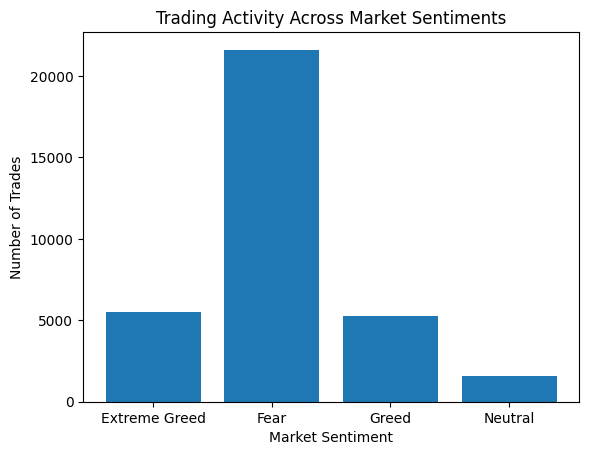

In [11]:
# ---- Trade Count by Sentiment ----
plt.figure()
plt.bar(sentiment_perf['classification'], sentiment_perf['total_trades'])
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")
plt.title("Trading Activity Across Market Sentiments")
plt.show()

In [12]:
# 9. STRATEGY INSIGHTS (LOGIC)

def trading_insight(row):
    if row['avg_pnl'] > sentiment_perf['avg_pnl'].mean():
        return "Favorable for aggressive trading"
    elif row['avg_pnl'] > 0:
        return "Moderate opportunity"
    else:
        return "High risk – reduce exposure"

sentiment_perf['strategy_recommendation'] = sentiment_perf.apply(trading_insight, axis=1)

print("\nStrategy Recommendations:")
print(sentiment_perf[['classification', 'strategy_recommendation']])


Strategy Recommendations:
  classification           strategy_recommendation
0  Extreme Greed              Moderate opportunity
1           Fear  Favorable for aggressive trading
2          Greed              Moderate opportunity
3        Neutral  Favorable for aggressive trading


In [15]:
#Conclusion
#Trader performance is significantly influenced by market sentiment.The analysis shows that Fear and Neutral market conditions produce above-average profitability, while Greed and Extreme Greed deliver lower risk-adjusted returns